# RCNN

### Environment checkup

In [1]:
!nvidia-smi

Fri Jun  6 15:17:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:3B:00.0 Off |                    0 |
|  0%   61C    P0             66W /  150W |    1085MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   32
  On-line CPU(s) list:    0-31
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   8
    Socket(s):            2
    Stepping:             7
    CPU(s) scaling MHz:   90%
    CPU max MHz:          3200.0000
    CPU min MHz:          800.0000
    BogoMIPS:             4200.00
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 s
                          s ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc 
                          art arch_perfmon pebs bts rep_good nopl xtopology nons
                          top_

In [3]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           125Gi        10Gi        75Gi        47Mi        40Gi       114Gi
Swap:          8.0Gi       4.8Gi       3.2Gi


### Preparation

In [4]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import selectivesearch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from tqdm import tqdm

In [5]:
# Paths to VOC data
VOC_ROOT = "./VOCdevkit/VOC2007"  # Change to your actual VOC2007 root
IMG_DIR = os.path.join(VOC_ROOT, "JPEGImages")
ANN_DIR = os.path.join(VOC_ROOT, "Annotations")
SPLIT_FILE = os.path.join(VOC_ROOT, "ImageSets/Main/trainval.txt")

VOC_CLASSES = [
    "background", 
    "aeroplane", 
    "bicycle", 
    "bird", 
    "boat",
    "bottle", 
    "bus", 
    "car", 
    "cat", 
    "chair",
    "cow", 
    "diningtable", 
    "dog", 
    "horse", 
    "motorbike",
    "person", 
    "pottedplant", 
    "sheep", 
    "sofa", 
    "train", 
    "tvmonitor"
]

# Create a mapping from class names to indices
CLASS2IDX = {name: i for i, name in enumerate(VOC_CLASSES)}
print("Class to Index Mapping:", CLASS2IDX)

Class to Index Mapping: {'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [6]:
from typing import Tuple, List

def parse_voc_xml(ann_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parse a VOC XML annotation file and extract ground-truth boxes and labels.

    Args:
        ann_path (str): Path to the .xml annotation file.

    Returns:
        gt_boxes (np.ndarray): Array of shape (N, 4) with [xmin, ymin, xmax, ymax].
        gt_labels (np.ndarray): Array of shape (N,) with integer class indices.
    """
    tree = ET.parse(ann_path)
    root = tree.getroot()
    gt_boxes = []
    gt_labels = []
    for obj in root.findall("object"):
        name_node = obj.find("name")
        bbox = obj.find("bndbox")
        if name_node is None or bbox is None:
            continue
        cls_name = name_node.text
        if cls_name not in CLASS2IDX:
            continue
        xmin_node = bbox.find("xmin")
        ymin_node = bbox.find("ymin")
        xmax_node = bbox.find("xmax")
        ymax_node = bbox.find("ymax")
        if None in (xmin_node, ymin_node, xmax_node, ymax_node):
            continue
        try:
            x1 = int(xmin_node.text)  # type: ignore
            y1 = int(ymin_node.text)  # type: ignore
            x2 = int(xmax_node.text)  # type: ignore
            y2 = int(ymax_node.text)  # type: ignore
        except (TypeError, ValueError):
            continue
        gt_boxes.append([x1, y1, x2, y2])
        gt_labels.append(CLASS2IDX[cls_name])
    return np.array(gt_boxes), np.array(gt_labels)


def compute_iou(boxA: List, boxB: List) -> float:
    """
    Compute Intersection over Union (IoU) between two bounding boxes.

    Args:
        boxA (List): [xmin, ymin, xmax, ymax] for proposal.
        boxB (List): [xmin, ymin, xmax, ymax] for ground-truth.

    Returns:
        float: IoU value in [0.0, 1.0].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    denom = boxAArea + boxBArea - interArea
    return interArea / float(denom) if denom > 0 else 0.0


def bbox_transform(proposal: List, gt: List) -> List:
    """
    Compute bounding-box regression targets (t_x, t_y, t_w, t_h) 
    given a proposal box and its matched ground-truth box.
    The formula is:
    t_x = (gx - px) / (pw + eps)
    t_y = (gy - py) / (ph + eps)
    t_w = log((gw + eps) / (pw + eps))
    t_h = log((gh + eps) / (ph + eps))

    where:
        - (px, py) is the top-left corner of the proposal box,
        - (pw, ph) is the width and height of the proposal box,
        - (gx, gy) is the top-left corner of the ground-truth box,
        - (gw, gh) is the width and height of the ground-truth box,
        - eps is a small value to avoid division by zero.

    Args:
        proposal (List): [xmin, ymin, xmax, ymax] of the candidate box.
        gt (List): [xmin, ymin, xmax, ymax] of the matched ground-truth.

    Returns:
        List: [t_x, t_y, t_w, t_h] regression targets.
    """
    px, py, pw, ph = proposal[0], proposal[1], proposal[2] - proposal[0], proposal[3] - proposal[1]
    gx, gy, gw, gh = gt[0], gt[1], gt[2] - gt[0], gt[3] - gt[1]
    eps = 1e-6  # Small epsilon to avoid division by zero
    tx = (gx - px) / (pw + eps)
    ty = (gy - py) / (ph + eps)
    tw = np.log((gw + eps) / (pw + eps))
    th = np.log((gh + eps) / (ph + eps))
    return [tx, ty, tw, th]

In [7]:
import multiprocessing as mp
import warnings
import h5py

# Suppress non-critical warnings (e.g., from selectivesearch or OpenCV)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def process_image(img_id: str):
    """
    Process a single VOC image: generate ~2000 selective-search proposals,
    rank by max IoU with any ground-truth box, keep top 1000, then return:
        - roi_imgs:         List[np.ndarray]        (224×224 crops)
        - roi_labels:       List[int]                (0=background or class idx)
        - roi_bbox_targets: List[List[float]]        ([t_x,t_y,t_w,t_h] or zeros)
        - roi_max_ious:     List[float]              (max IoU for each kept proposal)
    """
    img_path = os.path.join(IMG_DIR, f"{img_id}.jpg")
    ann_path = os.path.join(ANN_DIR, f"{img_id}.xml")
    img = cv2.imread(img_path)
    if img is None:
        return [], [], [], []

    height, width = img.shape[:2]
    gt_boxes, gt_labels = parse_voc_xml(ann_path)

    # 1) Generate ~2000 SS proposals
    _, regions = selectivesearch.selective_search(
        img, scale=500, sigma=0.9, min_size=10
    )

    # 2) Filter proposals by size/bounds, compute max IoU per proposal
    candidates: List[Tuple[List[int], float]] = []
    for region in regions:
        x, y, w, h = region["rect"]
        if w < 20 or h < 20:
            continue
        x2, y2 = x + w, y + h
        if x < 0 or y < 0 or x2 > width or y2 > height:
            continue

        proposal = [x, y, x2, y2]
        if gt_boxes.size > 0:
            ious = np.array([compute_iou(proposal, gt) for gt in gt_boxes])
            max_iou = float(ious.max())
        else:
            max_iou = 0.0

        candidates.append((proposal, max_iou))

    if not candidates:
        return [], [], [], []

    # 3) Sort by descending IoU, keep top 1000
    candidates.sort(key=lambda x: x[1], reverse=True)
    top_cands = candidates[:1000]

    roi_imgs = []
    roi_labels = []
    roi_bbox_targets = []
    roi_max_ious = []

    # 4) For each of the top proposals, assign labels/bbox targets or skip ambiguous
    for proposal, max_iou in top_cands:
        x1, y1, x2, y2 = proposal

        if max_iou >= 0.5:
            # Positive: find matching GT index
            ious = np.array([compute_iou(proposal, gt) for gt in gt_boxes])
            gt_idx = int(ious.argmax())
            label = int(gt_labels[gt_idx])
            bbox_target = bbox_transform(proposal, gt_boxes[gt_idx])
        elif max_iou <= 0.1:
            # Clear negative (background)
            label = 0
            bbox_target = [0.0, 0.0, 0.0, 0.0]
        else:
            # Ambiguous (0.1 < IoU < 0.5): skip
            continue

        # Crop and resize ROI
        crop = img[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
            continue
        crop_resized = cv2.resize(crop, (224, 224))

        roi_imgs.append(crop_resized)
        roi_labels.append(label)
        roi_bbox_targets.append(bbox_target)
        roi_max_ious.append(max_iou)

    return roi_imgs, roi_labels, roi_bbox_targets, roi_max_ious


# Path where your ROI dataset will live
HDF5_PATH = "./voc_rois.h5"

# If existing, delete so we can recreate fresh
if os.path.exists(HDF5_PATH):
    print(f"Removing existing HDF5 file: {HDF5_PATH}")
    os.remove(HDF5_PATH)

# Create HDF5 with four extendable datasets:
#   - 'images': shape=(0,224,224,3), dtype=uint8
#   - 'labels': shape=(0,), dtype=int32
#   - 'bboxes': shape=(0,4), dtype=float32
#   - 'ious':   shape=(0,), dtype=float32
h5f = h5py.File(HDF5_PATH, "w")
h5f.create_dataset(
    "images",
    shape=(0, 224, 224, 3),
    maxshape=(None, 224, 224, 3),
    dtype="uint8",
    chunks=(1, 224, 224, 3),
)
h5f.create_dataset(
    "labels",
    shape=(0,),
    maxshape=(None,),
    dtype="int32",
    chunks=(1024,),
)
h5f.create_dataset(
    "bboxes",
    shape=(0, 4),
    maxshape=(None, 4),
    dtype="float32",
    chunks=(1024, 4),
)
h5f.create_dataset(
    "ious",
    shape=(0,),
    maxshape=(None,),
    dtype="float32",
    chunks=(1024,),
)

# Keep track of how many ROIs we’ve written so far
current_count = 0

# Use multiprocessing to process images in parallel (reserve 2 cores)
num_workers = max(1, mp.cpu_count() - 2)
print(f"Using {num_workers} workers for parallel processing...")
with open(SPLIT_FILE) as f:
    img_ids = [x.strip() for x in f.readlines()]

print(f"Processing {len(img_ids)} images and streaming to HDF5...")
with mp.Pool(num_workers) as pool:
    for roi_imgs, roi_labels, roi_bboxes, roi_ious in tqdm(
        pool.imap(process_image, img_ids),
        total=len(img_ids),
        desc="Preparing VOC dataset (mp)",
    ):
        batch_size = len(roi_imgs)
        if batch_size == 0:
            continue

        # Resize each dataset to accommodate new entries
        h5f["images"].resize(current_count + batch_size, axis=0)    # type: ignore
        h5f["labels"].resize(current_count + batch_size, axis=0)    # type: ignore
        h5f["bboxes"].resize(current_count + batch_size, axis=0)    # type: ignore
        h5f["ious"].resize(current_count + batch_size, axis=0)      # type: ignore

        # Write image data (uint8) directly; it’s already 224 x 224 x 3
        h5f["images"][current_count : current_count + batch_size, ...] = np.stack(roi_imgs)   # type: ignore

        # Write labels, bbox targets, and IoU values
        h5f["labels"][current_count : current_count + batch_size] = np.array(roi_labels, dtype=np.int32)        # type: ignore
        h5f["bboxes"][current_count : current_count + batch_size, :] = np.array(roi_bboxes, dtype=np.float32)   # type: ignore
        h5f["ious"][current_count : current_count + batch_size] = np.array(roi_ious, dtype=np.float32)          # type: ignore

        current_count += batch_size

h5f.close()
print(f"Done. Total ROIs on disk: {current_count}")

Using 30 workers for parallel processing...
Processing 5011 images and streaming to HDF5...


Preparing VOC dataset (mp): 100%|██████████| 5011/5011 [11:28<00:00,  7.28it/s]  


Done. Total ROIs on disk: 790649


In [8]:
import torch
import h5py
from torch.utils.data import Dataset

class VOCRCNNDataset(Dataset):
    """
    PyTorch Dataset for RCNN using an HDF5 file. Each worker opens the file
    once in __init__, then __getitem__ indexes into four datasets:
        'images', 'labels', 'bboxes', and 'ious'.

    Returns a tuple (image_tensor, class_label, bbox_target, iou_value).

    Args:
        hdf5_path (str): Path to the HDF5 file containing ROI data.
        transform (callable, optional): A torchvision transform to apply to each ROI.
    """
    def __init__(self, hdf5_path: str, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform

        # Open HDF5 file in read-only mode; each worker gets its own handle
        self.h5f = h5py.File(self.hdf5_path, "r")
        self.images_ds = self.h5f["images"]
        self.labels_ds = self.h5f["labels"]
        self.bboxes_ds = self.h5f["bboxes"]
        self.ious_ds   = self.h5f["ious"]

    def __len__(self) -> int:
        # Total number of ROIs stored on disk
        return self.images_ds.shape[0]  # type: ignore

    def __getitem__(self, idx: int):
        # Read raw uint8 image (224×224×3) and convert to PIL→Tensor
        img_np = self.images_ds[idx]                 # type: ignore
        label = int(self.labels_ds[idx])             # type: ignore
        bbox = self.bboxes_ds[idx].astype("float32") # type: ignore
        iou   = float(self.ious_ds[idx])             # type: ignore

        if self.transform:
            img = self.transform(img_np)
        else:
            # If no transform, convert to tensor and normalize to [0,1]
            img = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0

        return img, torch.tensor(label, dtype=torch.long), torch.tensor(bbox, dtype=torch.float32), torch.tensor(iou, dtype=torch.float32)

    def __del__(self):
        # Ensure HDF5 file handle is closed when Dataset is destroyed
        try:
            self.h5f.close()
        except Exception:
            pass


In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Preprocessing pipeline (same as before)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # ImageNet stats
                         std=[0.229, 0.224, 0.225])     # ImageNet stats
])
print(f"preprocessing: {preprocess}")

# Create Dataset and DataLoader
dataset = VOCRCNNDataset(hdf5_path="./voc_rois.h5", transform=preprocess)
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,       # Adjust based on your CPU—each worker will open the HDF5 file
    pin_memory=True,     # Speeds up transfer to GPU if you use one
    drop_last=False
)
print(f"Dataset: {dataset.hdf5_path}")
print(f"DataLoader: {dataloader.batch_size} batch size, {dataloader.num_workers} workers")


print(f"Dataset size: {len(dataset)} ROIs")
print("Sampling one batch to verify shapes:")
batch_imgs, batch_labels, batch_bboxes, batch_ious = next(iter(dataloader))
print("Images:", batch_imgs.shape)   # Expected: (8, 3, 224, 224)
print("Labels:", batch_labels.shape) # Expected: (8,)
print("BBoxes:", batch_bboxes.shape) # Expected: (8, 4)
print("IoUs:", batch_ious.shape)     # Expected: (8,)

preprocessing: Compose(
    ToPILImage()
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Dataset: ./voc_rois.h5
DataLoader: 8 batch size, 8 workers
Dataset size: 790649 ROIs
Sampling one batch to verify shapes:
Images: torch.Size([8, 3, 224, 224])
Labels: torch.Size([8])
BBoxes: torch.Size([8, 4])
IoUs: torch.Size([8])


### Explore data

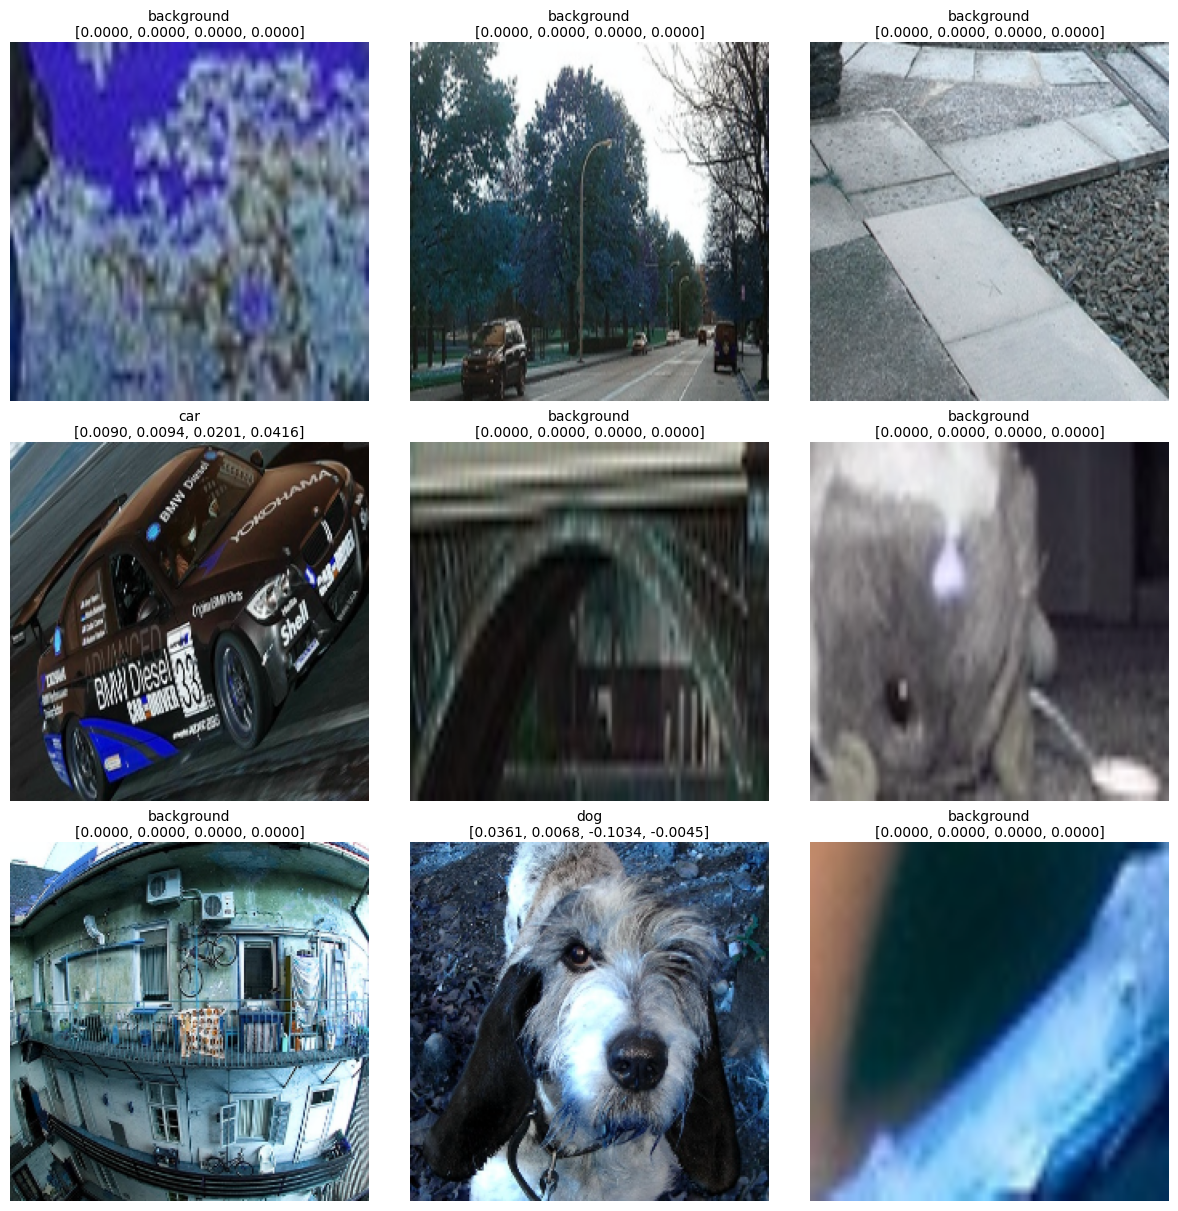

In [10]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

IDX2CLASS = {i: name for i, name in enumerate(VOC_CLASSES)}

def show_rois_grid(
    dataset: torch.utils.data.Dataset,
    rows: int = 3,
    cols: int = 3
):
    """
    Display a grid of ROI crops from the dataset with legible titles.

    Args:
        dataset (torch.utils.data.Dataset): Dataset returning (image_tensor, label, bbox).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    total = len(dataset)    # type: ignore
    if total == 0:
        print("Dataset is empty.")
        return

    n = rows * cols
    n = min(n, total)
    # Randomly sample n unique indices
    idxs = random.sample(range(total), n)

    # Create subplots: one axis per ROI
    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(cols * 4, rows * 4),
        constrained_layout=True
    )

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs):
        img_tensor, label_tensor, bbox_tensor, _ = dataset[idx]

        # Convert from (C, H, W) to (H, W, C), undo normalization
        npimg = img_tensor.permute(1, 2, 0).cpu().numpy()
        npimg = (npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        npimg = np.clip(npimg, 0.0, 1.0)

        ax.imshow(npimg)
        ax.axis("off")

        cls_name = IDX2CLASS[int(label_tensor)]
        bbox_np = bbox_tensor.cpu().numpy() if hasattr(bbox_tensor, "cpu") else np.array(bbox_tensor)
        # Print 4 values per line, rounded to 4 decimals
        bbox_lines = []
        for i in range(0, len(bbox_np), 4):
            line = "[" + ", ".join(f"{v:.4f}" for v in bbox_np[i:i+4]) + "]"
            bbox_lines.append(line)
        bbox_str = "\n".join(bbox_lines)
        ax.set_title(
            f"{cls_name}\n{bbox_str}",
            fontsize=10,
            pad=4
        )


    plt.show()


# Example usage: display a 3×3 grid of ROIs
show_rois_grid(dataset, rows=3, cols=3)


### Train SVM(Support Vector Machine) within R-CNN structure

In [11]:
import torch
import torch.nn as nn

# 1) Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2) FeatureExtractor definition
class FeatureExtractor(nn.Module):
    """
    A simple CNN-based feature extractor for R-CNN. 
    Takes an input tensor of shape (B, 3, 224, 224) and outputs a 256-dim feature vector per ROI.

    Architecture:
        - Conv2d(3 => 32, kernel_size=3, stride=2, padding=1) + ReLU
        - MaxPool2d(kernel_size=2)
        - Conv2d(32 => 64, kernel_size=3, stride=2, padding=1) + ReLU
        - MaxPool2d(kernel_size=2)
        - AdaptiveAvgPool2d(output_size=(1, 1))
        - Flatten
        - Linear(64 => 256) + ReLU

    This avoids hard-coding the feature map size (64 x 14 x 14) by using adaptive pooling.
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        # After AdaptiveAvgPool2d, feature map is (B, 64, 1, 1) => Flatten to (B, 64)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=64, out_features=256)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: compute a 256-D feature vector for each input ROI.

        Args:
            x (torch.Tensor): Input tensor of shape (B, 3, 224, 224).

        Returns:
            torch.Tensor: Output tensor of shape (B, 256).
        """
        x = self.conv(x)      # => (B, 64, 1, 1)
        x = self.flatten(x)   # => (B, 64)
        x = self.fc(x)        # => (B, 256)
        x = self.relu(x)
        return x

# 3) Instantiate and move to device
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()  # Set to evaluation mode (no dropout/batchnorm behavior)

# 4) Quick sanity check
dummy = torch.randn(1, 3, 224, 224, device=device)  # Batch size=1, 3-channel 224×224
with torch.no_grad():
    feats = feature_extractor(dummy)

print(f"Feature vector shape: {feats.shape}")       # Expected: torch.Size([1, 256])

Using device: cuda


Feature vector shape: torch.Size([1, 256])


In [12]:
"""
This cell extracts CNN features for all ROI crops in the dataset,
and assembles them into NumPy arrays for SVM classification and bounding-box regression,
including IoU values.

- all_features:     list of (batch_size, 256)-shaped NumPy arrays from the feature extractor
- all_labels:       list of (batch_size,)        NumPy arrays of class labels
- all_bbox_targets: list of (batch_size, 4)      NumPy arrays of bbox regression targets
- all_ious:         list of (batch_size,)        NumPy arrays of IoU values

After looping over the DataLoader, we concatenate along axis=0 to produce:
    X      = (N, 256)     # feature matrix for all N ROIs
    y_cls  = (N,)         # class labels for each ROI
    y_bbox = (N, 4)       # bbox regression targets for each ROI
    y_iou  = (N,)         # max IoU per ROI
"""

import numpy as np
from tqdm import tqdm

# Containers for batched outputs
all_features = []
all_labels = []
all_bbox_targets = []
all_ious = []

# Disable gradient computation since we're only doing inference
with torch.no_grad():
    for imgs, labels, bboxes, ious in tqdm(dataloader, desc="Extracting features"):
        imgs = imgs.to(device)
        feats = feature_extractor(imgs).cpu().numpy()  # (batch, 256)
        all_features.append(feats)
        all_labels.append(labels.numpy())              # (batch,)
        all_bbox_targets.append(bboxes.numpy())        # (batch,4)
        all_ious.append(ious.numpy())                  # (batch,)

# Concatenate along axis=0:
X     = np.concatenate(all_features,      axis=0)   # shape: (N, 256)
y_cls = np.concatenate(all_labels,        axis=0)   # shape: (N,)
y_bbox = np.concatenate(all_bbox_targets, axis=0)   # shape: (N, 4)
y_iou = np.concatenate(all_ious,          axis=0)   # shape: (N,)

print(f"Total ROIs processed: {X.shape[0]}")
print(f"Feature matrix shape:       {X.shape}")       # (N, 256)
print(f"Class labels shape:         {y_cls.shape}")   # (N,)
print(f"BBox targets shape:         {y_bbox.shape}")  # (N, 4)
print(f"IoU values shape:           {y_iou.shape}")   # (N,)


Extracting features: 100%|██████████| 98832/98832 [09:56<00:00, 165.56it/s]


Total ROIs processed: 790649
Feature matrix shape:       (790649, 256)
Class labels shape:         (790649,)
BBox targets shape:         (790649, 4)
IoU values shape:           (790649,)


In [13]:
import numpy as np
import time
from sklearn.linear_model import LinearRegression


# Inspect class distribution
class_counts = np.bincount(y_cls)
print("Class distribution (label: count):")
for idx, count in enumerate(class_counts):
    class_name = IDX2CLASS.get(idx, str(idx))
    print(f"  {idx:2d} ({class_name:15s}): {count}")

# 1) Create a boolean mask for “clean positives”
clean_pos_mask = (y_cls != 0) & (y_iou >= 0.7)

X_clean_pos      = X[clean_pos_mask, :]       # (N_clean_pos, 256)
y_bbox_clean_pos = y_bbox[clean_pos_mask, :]   # (N_clean_pos, 4)

print(f"Total ROIs:             {X.shape[0]:,}")
print(f"Positive ROIs (IoU≥0.5): {np.sum(y_cls != 0):,}")
print(f"‘Clean’ positives (IoU≥0.7): {np.sum(clean_pos_mask):,}")
print("-" * 40)

# 2) Train bounding-box regressor on “clean” positives
start_time = time.time()
regressor = LinearRegression(fit_intercept=True, n_jobs=-1)
regressor.fit(X_clean_pos, y_bbox_clean_pos)
elapsed = time.time() - start_time
print(f"sklearn LinearRegression finished in {elapsed:.1f} sec.")

# 3) Quick sanity check on a few clean positives
n_test = min(1000, X_clean_pos.shape[0])
test_idxs = np.random.choice(X_clean_pos.shape[0], size=n_test, replace=False)
X_test = X_clean_pos[test_idxs, :]
y_test = y_bbox_clean_pos[test_idxs, :]

y_pred = regressor.predict(X_test)
l2_errors = np.linalg.norm(y_pred - y_test, axis=1)
print(f"Average L2 error (IoU≥0.7 subset): {l2_errors.mean():.4f}")


Class distribution (label: count):
   0 (background     ): 603698
   1 (aeroplane      ): 6683
   2 (bicycle        ): 5877
   3 (bird           ): 8438
   4 (boat           ): 3543
   5 (bottle         ): 1545
   6 (bus            ): 5312
   7 (car            ): 22198
   8 (cat            ): 11365
   9 (chair          ): 5317
  10 (cow            ): 5651
  11 (diningtable    ): 6448
  12 (dog            ): 13833
  13 (horse          ): 8113
  14 (motorbike      ): 10772
  15 (person         ): 39436
  16 (pottedplant    ): 5482
  17 (sheep          ): 3966
  18 (sofa           ): 8670
  19 (train          ): 10442
  20 (tvmonitor      ): 3860
Total ROIs:             790,649
Positive ROIs (IoU≥0.5): 186,951
‘Clean’ positives (IoU≥0.7): 76,835
----------------------------------------
sklearn LinearRegression finished in 1.1 sec.
Average L2 error (IoU≥0.7 subset): 0.1720


### Train Boundary Box(bbox) regression model within R-CNN structure

In [14]:
import numpy as np
import time

# 1) Filter positive ROIs (exclude background, label=0)
pos_mask = y_cls != 0
X_pos = X[pos_mask]            # Features for positive ROIs: shape (N_pos, 256)
y_bbox_pos = y_bbox[pos_mask]  # BBox targets for positives: shape (N_pos, 4)

print(f"Number of positive ROIs: {X_pos.shape[0]:,}")
print(f"Feature matrix shape (positives): {X_pos.shape}")
print(f"BBox targets shape (positives):  {y_bbox_pos.shape}")
print("-" * 40)

# 2) Attempt GPU-accelerated regression with cuML
use_cuml_reg = False
try:
    from cuml.linear_model import LinearRegression as cuLinearRegression
    import cupy as cp
    use_cuml_reg = True
    print("cuML LinearRegression detected: will train regressor on GPU.")
except ImportError:
    from sklearn.linear_model import LinearRegression
    use_cuml_reg = False
    print("cuML not found → falling back to sklearn's LinearRegression (CPU).")

# 3) Train the bounding-box regressor
start_time = time.time()

if use_cuml_reg:
    # Convert to GPU arrays
    X_gpu = cp.asarray(X_pos.astype(np.float32))      # cuML expects float32
    y_gpu = cp.asarray(y_bbox_pos.astype(np.float32)) # shape (N_pos, 4)

    # Instantiate cuML’s LinearRegression
    # Note: fit_intercept=True by default
    regressor = cuLinearRegression(fit_intercept=True)

    # Fit on GPU
    regressor.fit(X_gpu, y_gpu)
    duration = time.time() - start_time
    print(f"cuML LinearRegression training complete (on GPU) in {duration:.1f} sec.")

else:
    # scikit-learn’s LinearRegression runs on CPU
    # When N_pos is large, this may take some time
    regressor = LinearRegression(fit_intercept=True, n_jobs=-1)

    # Fit on CPU
    regressor.fit(X_pos, y_bbox_pos)
    duration = time.time() - start_time
    print(f"sklearn LinearRegression training complete (on CPU) in {duration:.1f} sec.")

# 4) Quick Sanity Check on a Small Subset
# Select 1,000 random positive indices for testing
n_test = min(1000, X_pos.shape[0])
test_idxs = np.random.choice(X_pos.shape[0], size=n_test, replace=False)
X_test = X_pos[test_idxs]
y_test = y_bbox_pos[test_idxs]

if use_cuml_reg:
    X_test_gpu = cp.asarray(X_test.astype(np.float32))
    y_pred_gpu = regressor.predict(X_test_gpu)  # shape (n_test, 4)
    y_pred = cp.asnumpy(y_pred_gpu)
else:
    y_pred = regressor.predict(X_test)

# Compute average L2 regression error on this subset
l2_errors = np.linalg.norm(y_pred - y_test, axis=1)
print(f"Average L2 bbox error on {n_test} samples: {l2_errors.mean():.4f}")


Number of positive ROIs: 186,951
Feature matrix shape (positives): (186951, 256)
BBox targets shape (positives):  (186951, 4)
----------------------------------------
cuML LinearRegression detected: will train regressor on GPU.
cuML LinearRegression training complete (on GPU) in 2.4 sec.
Average L2 bbox error on 1000 samples: 2.6656


In [15]:
import random
import numpy as np
import cv2
import torch
from typing import List, Tuple
import matplotlib.pyplot as plt

def predict_on_image(
    img_path: str,
    feature_extractor: torch.nn.Module,
    svm_model,
    bbox_regressor,
    preprocess: torch.nn.Module,
    device: torch.device
):
    """
    Run R-CNN inference on a single image using a CNN feature extractor, an SVM classifier,
    and a linear bbox regressor. Displays the final detections (excluding background).

    Args:
        img_path (str): Path to the input image (.jpg).
        feature_extractor (nn.Module): CNN module that maps (B,3,224,224) → (B,256).
        svm_model: Trained SVM classifier with `predict()` method accepting NumPy array (N,256).
        bbox_regressor: Trained regressor with `predict()` accepting NumPy array (N,256).
        preprocess (torch.nn.Module): Transform pipeline (e.g., ToPILImage→ToTensor→Normalize).
        device (torch.device): Device for CNN inference (“cuda” or “cpu”).

    Returns:
        None (displays image with boxes and class labels in a matplotlib figure).
    """
    # 1) Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image: {img_path}")
        return

    height, width = img.shape[:2]

    # 2) Generate Selective Search proposals
    _, regions = selectivesearch.selective_search(
        img, scale=500, sigma=0.9, min_size=10
    )

    # 3) Filter proposals: remove too-small or out-of-bounds
    proposals: List[List[int]] = []
    for region in regions:
        x, y, w, h = region["rect"]
        if w < 20 or h < 20:
            continue
        x2, y2 = x + w, y + h
        if x < 0 or y < 0 or x2 > width or y2 > height:
            continue
        proposals.append([x, y, x2, y2])

    # 4) Randomly sample up to 200 proposals if too many
    if len(proposals) > 200:
        proposals = random.sample(proposals, 200)

    # 5) Prepare ROI crops and corresponding proposal boxes
    roi_tensors: List[torch.Tensor] = []
    valid_proposals: List[List[int]] = []
    for (x1, y1, x2, y2) in proposals:
        crop = img[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
            continue
        # Resize to 224×224, apply preprocess, and add batch dim
        crop_resized = cv2.resize(crop, (224, 224))
        tensor = preprocess(crop_resized).unsqueeze(0)  # Shape: (1,3,224,224)
        roi_tensors.append(tensor)
        valid_proposals.append([x1, y1, x2, y2])

    if not roi_tensors:
        print("No valid ROI proposals found.")
        return

    # 6) Stack all ROI tensors into a single batch
    inputs = torch.cat(roi_tensors, dim=0).to(device)  # Shape: (N_rois,3,224,224)

    # 7) Extract features (no gradients)
    feature_extractor.eval()
    with torch.no_grad():
        feats = feature_extractor(inputs)            # Tensor: (N_rois, 256)
        feats_np = feats.cpu().numpy()               # NumPy: (N_rois, 256)

    # 8) Classification and bounding-box regression (NumPy)
    pred_cls = svm_model.predict(feats_np)           # Shape: (N_rois,)
    pred_bbox_deltas = bbox_regressor.predict(feats_np)  # Shape: (N_rois, 4)

    # 9) Collect final detections (skip background label=0)
    final_boxes: List[Tuple[int,int,int,int]] = []
    final_labels: List[str] = []

    for i, cls_idx in enumerate(pred_cls):
        if int(cls_idx) == 0:
            continue  # background, skip

        # Original proposal
        x1, y1, x2, y2 = valid_proposals[i]
        pw, ph = x2 - x1, y2 - y1

        # Apply regression deltas (t_x, t_y, t_w, t_h)
        tx, ty, tw, th = pred_bbox_deltas[i]
        gx = x1 + tx * pw
        gy = y1 + ty * ph
        gw = pw * np.exp(tw)
        gh = ph * np.exp(th)

        # Convert to int and clamp to image bounds
        x1n = int(max(0, gx))
        y1n = int(max(0, gy))
        x2n = int(min(width, gx + gw))
        y2n = int(min(height, gy + gh))

        final_boxes.append((x1n, y1n, x2n, y2n))
        final_labels.append(VOC_CLASSES[int(cls_idx)])

    # 10) Visualize results
    img_disp = img.copy()
    for (x1, y1, x2, y2), label in zip(final_boxes, final_labels):
        # Draw rectangle (red) and label text (yellow)
        cv2.rectangle(img_disp, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
        cv2.putText(
            img_disp,
            label,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            color=(0, 255, 255),
            thickness=2,
            lineType=cv2.LINE_AA
        )

    # Convert BGR → RGB for matplotlib
    img_rgb = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("R-CNN (SVM + Linear Regression) Predictions")
    plt.show()


background     : 603,698
aeroplane      : 6,683
bicycle        : 5,877
bird           : 8,438
boat           : 3,543
bottle         : 1,545
bus            : 5,312
car            : 22,198
cat            : 11,365
chair          : 5,317
cow            : 5,651
diningtable    : 6,448
dog            : 13,833
horse          : 8,113
motorbike      : 10,772
person         : 39,436
pottedplant    : 5,482
sheep          : 3,966
sofa           : 8,670
train          : 10,442
tvmonitor      : 3,860
[LibLinear]iter  1 act 1.052e+05 pre 1.052e+05 delta 3.487e-01 f 2.246e+05 |g| 6.034e+05 CG   1
cg reaches trust region boundary
iter  2 act 3.957e+03 pre 3.952e+03 delta 5.050e-01 f 1.194e+05 |g| 1.733e+04 CG   1
cg reaches trust region boundary
iter  3 act 3.977e+03 pre 3.983e+03 delta 6.208e-01 f 1.154e+05 |g| 2.178e+04 CG   2
cg reaches trust region boundary
iter  4 act 4.833e+03 pre 4.766e+03 delta 9.543e-01 f 1.115e+05 |g| 1.400e+04 CG   3
cg reaches trust region boundary
iter  5 act 4.012e+03 pre 

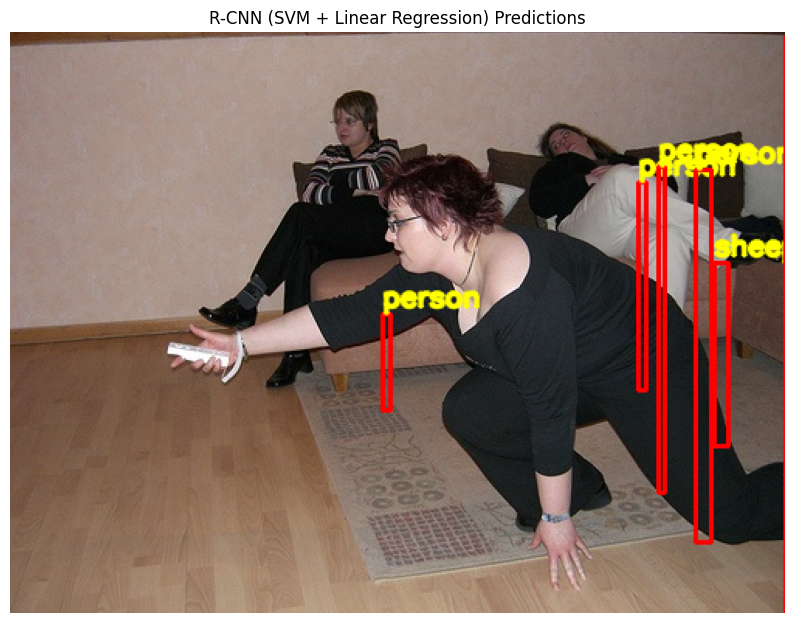

In [17]:
import numpy as np
from sklearn.svm import LinearSVC

# 1) (Optional) Inspect imbalance
class_counts = np.bincount(y_cls)
for idx, cnt in enumerate(class_counts):
    print(f"{IDX2CLASS[idx]:15s}: {cnt:,}")

# 2) Fit on all samples, but balance class weights
svm = LinearSVC(
    max_iter=2000,
    verbose=1,
    class_weight="balanced",  # automatically reweights each class
    dual=False
)
svm.fit(X, y_cls)

# 3) Now you can run predict_on_image() as before:
img_path = os.path.join(IMG_DIR, f"{random.choice(img_ids)}.jpg")
predict_on_image(
    img_path=img_path,
    feature_extractor=feature_extractor,
    svm_model=svm,
    bbox_regressor=regressor,
    preprocess=preprocess,
    device=device
)

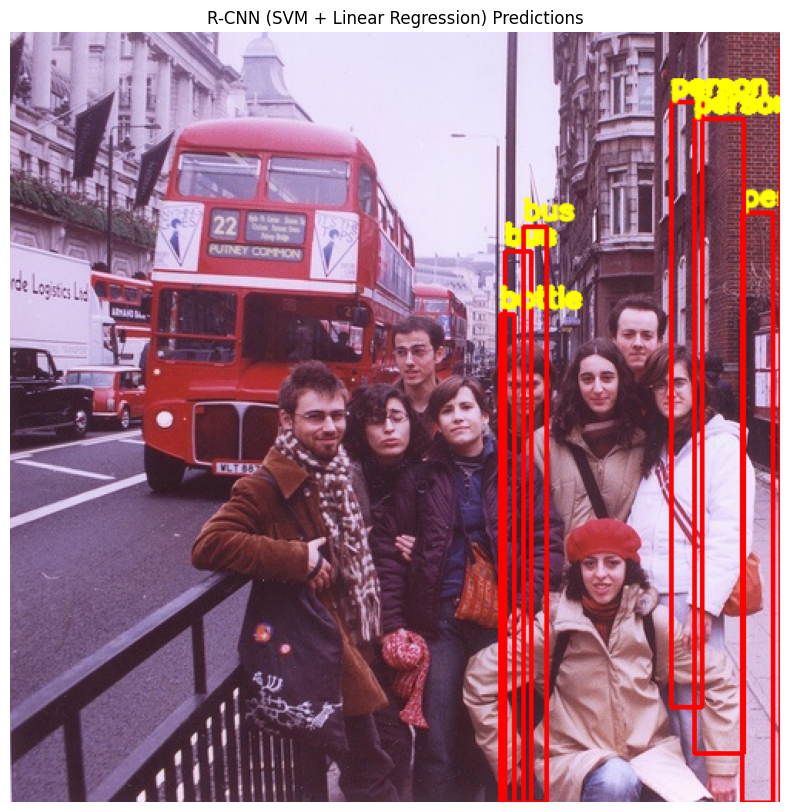

In [21]:
img_path = os.path.join(IMG_DIR, f"{random.choice(img_ids)}.jpg")
predict_on_image(
    img_path=img_path,
    feature_extractor=feature_extractor,
    svm_model=svm,
    bbox_regressor=regressor,
    preprocess=preprocess,
    device=device
)

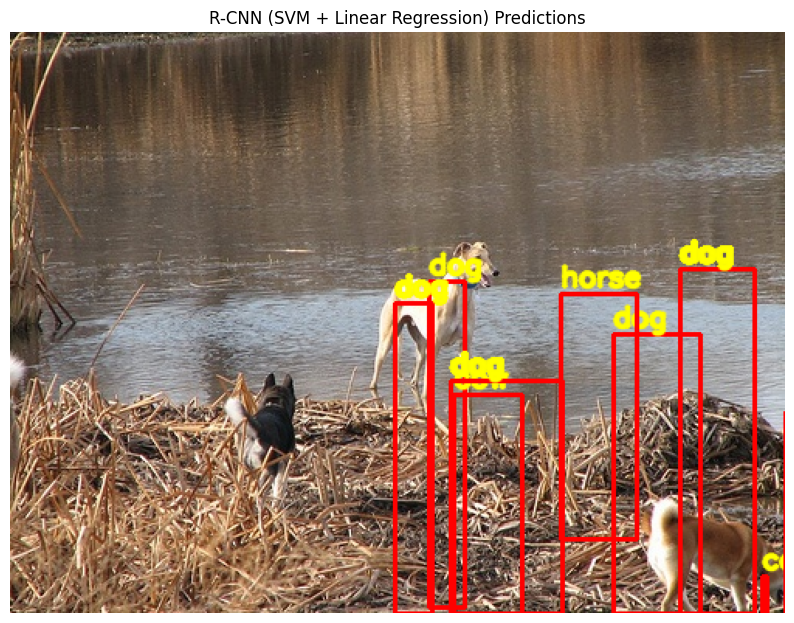

In [27]:
img_path = os.path.join(IMG_DIR, f"{random.choice(img_ids)}.jpg")
predict_on_image(
    img_path=img_path,
    feature_extractor=feature_extractor,
    svm_model=svm,
    bbox_regressor=regressor,
    preprocess=preprocess,
    device=device
)